<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/1006_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Overview  

기계 번역 시, Vanila seq2seq은 하나의 단어를 번역할 때 조차도 전체 문장에 대한 정보를 활용했다. 하지만 seq2seq with Attention은 우리 인간이 번역 활동을 하듯이 번역하고자 하는 특정 target word (in Decoder)를 번역할 때, 그것과 관련된 것들 (a few input words)만을 참조한다. Attention 메커니즘을 이용한 이 기계 번역은 기존 방법 보다 더 좋은 성능을 보여준다.

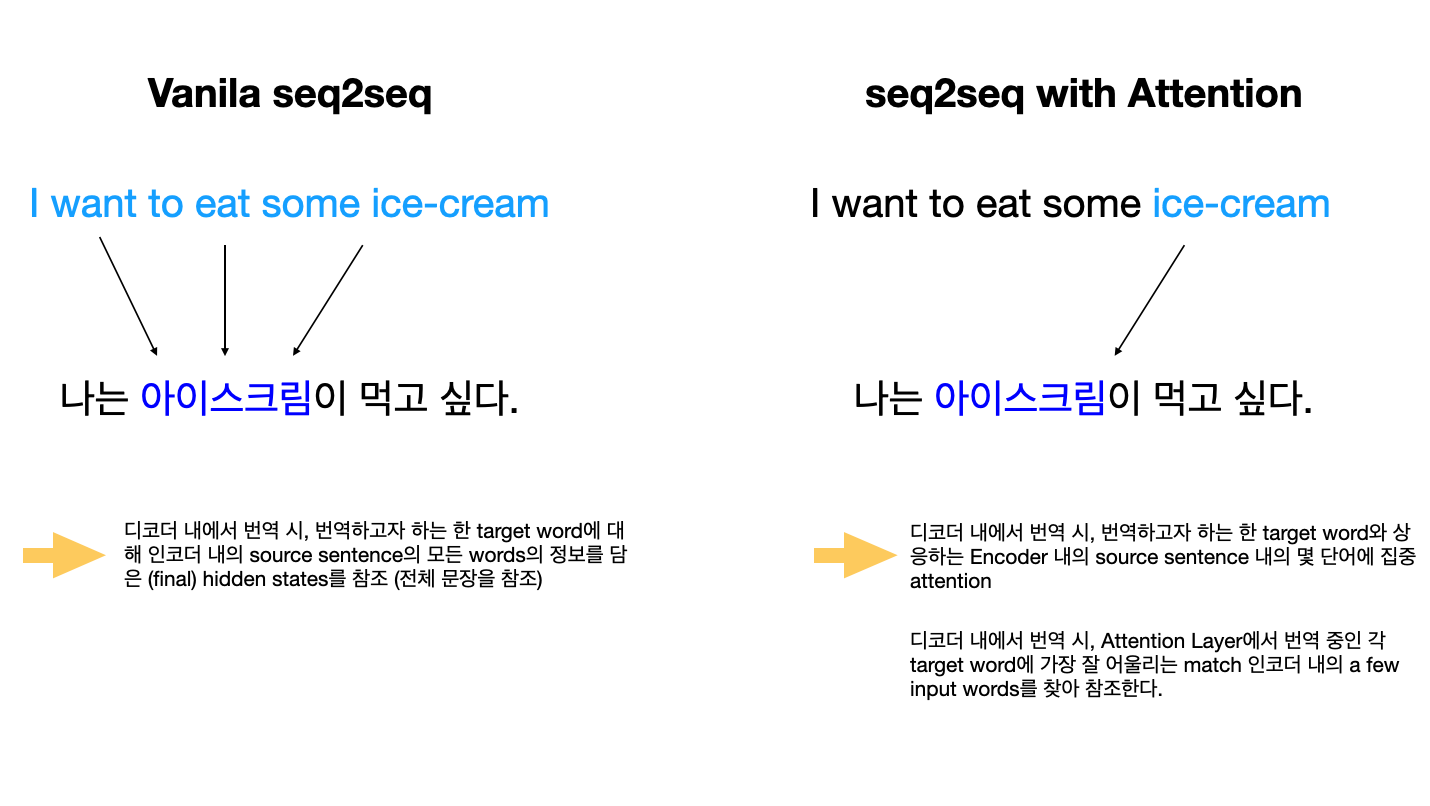

In [7]:
Image('12.png',width=700)

# 1. Motivation 

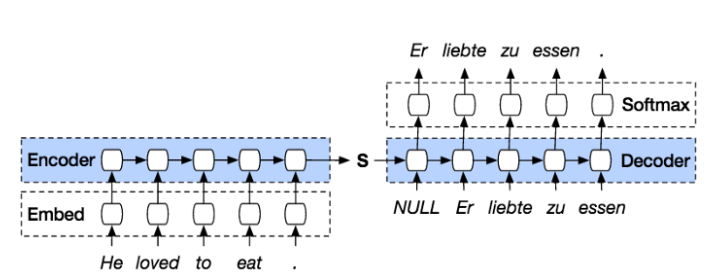

In [ ]:
Image('2.PNG',width=600)

$\ \ $우리는 이전 시간에 seq2seq에 대해 알아보았다. 이것은 Encoder와 Decoder로 구성된 아키텍처였고, 시퀀스를 입력으로 받아 적절히 처리한 뒤 다시 시퀀스 형태로 자료를 출력하는 역할을 수행했다. **하지만 이 seq2seq에는 사실 한계가 있다.**   
  
- (1) 이것의 Encoder 파트는 가변 길이의 입력 시퀀스를 받은 뒤, 그것의 정보를 담은 최종 은닉 상태 벡터를 Decoder로 전달할 때, 그것을 **고정 길이 벡터 fixed length vector**로 전달한다. 예를 들어 말하자면, 입력 시퀀스로 '나는 한국인이다'가 들어오든, '나는 대한민국에서 태어나 현재 서울에 살고 있고 컴퓨터과학을 공부하는 사람이다'가 들어오든, 동일한 크기의 벡터 (고정된 길이의 벡터)로 그 정보가 저장된다. 이것은 문제적이다. 어떻게 짧은 길이의 입력 시퀀스와 긴 길이의 입력 시퀀스가 동일한 크기의 벡터에 담길 수 있단 말인가? 매우 긴 길이의 입력 시퀀스가 입력될 시, 적당한 크기로 설계된 은닉 상태 벡터는 그것의 정보를 다 담지 못할 수 있다. 그렇다면, 이것은 **정보 손실**을 불러일으킬 것이다.

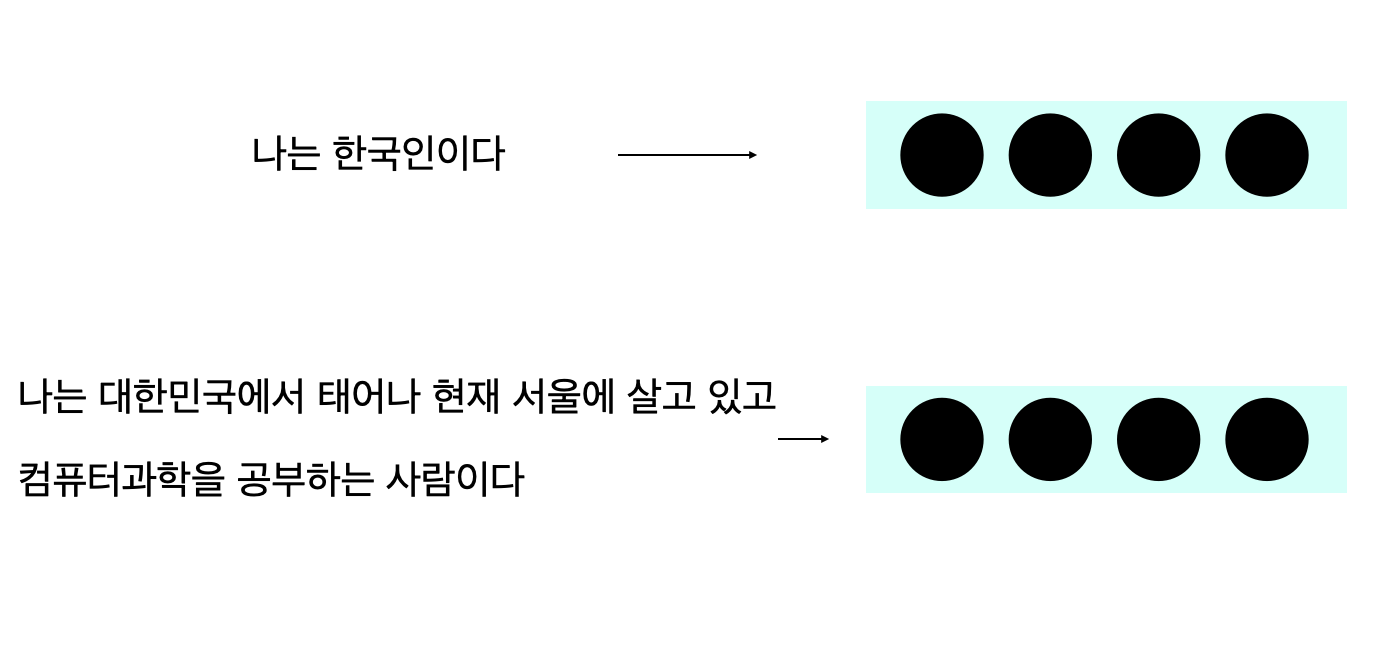

In [ ]:
Image('1.png',width=600)

- (2) seq2seq은 입력받는 input sentence 길이가 길수록 성능이 BLEU 점수가 떨어진다 (성능이 떨어진다.) 그 이유는 위 Issue (1)과 관련된다. 긴 문장이 단 하나의 은닉 상태로 정보가 압축되면, 정보 손실이 일어날 것이기 때문이다. 또 하나의 다른 가능한 이유는 Encoder에서 RNN의 길이가 긴 경우 Vanishing Gradient 현상이 일어날 수 있다. (하지만 LSTM을 사용한다면 이 가능성을 많은 경우에 피할 수 있다.)

# 2. Resolution  

어텐션은 위 Issue를 해결하고자 고안되었다. 이것은 디코더에서 target sentence를 예측하는 동안 매 timestep 마다 그것의 각 word와 가장 유관한 source sentence의 word가 무엇인지를 참조하는 메커니즘을 seq2seq에 첨가한 방법이다. 

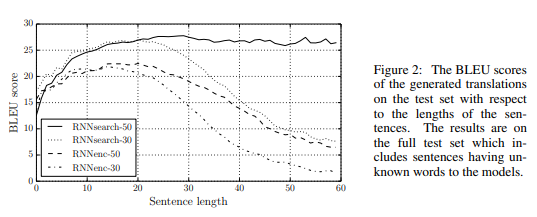

In [ ]:
Image('1.PNG')

위 그래프는 Attention을 처음 소개한 논문 [1]의 결과를 보여준다. 주목할 점은 RNNsearch( RNN with Attention)은 문장 길이가 긴 경우에도 RNNenc(without Attention) 보다 BLEU 점수가 좋다는 점이다. 즉, 어텐션을 사용할 때, 위 Motivation에서 제기된 issue가 다소 해결된다는 점을 알 수 있다.

# 3. Attention Mechanisms

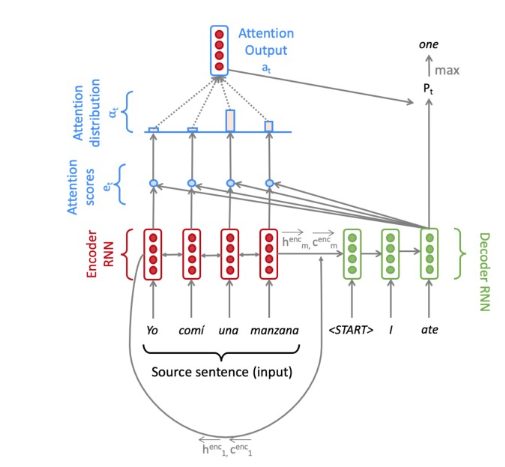

In [ ]:
Image('3.PNG',width=600)

## 3.1 Encoder (Bidirectional RNN)


어텐션 메커니즘은 보통 seq2seq에 첨가되는 것으로 사용된다. 우리는 Encoder, Decoder로 구성된 이 seq2seq에 어텐션이 적용된 아키텍처를 고려한다. 따라서 그것의 한 부분인 어텐션이 적용된 Encoder에 대해서 먼저 알아보겠다.

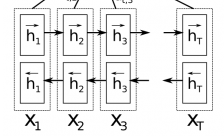

In [ ]:
Image('4.PNG',width=400)

- seq2seq의 인코더에서 Vanila RNN을 사용 시, hidden states는 과거 시점에서 미래 시점으로 계산된다. 가령, '나는 강아지를 좋아한다'는 '나는' $\to$ '강아지를' $\to$'좋아한다'  순으로 hidden states가 계산된다. 하지만 역순으로 hidden states를 계산한 것도 고려한다면 우리는 inputs에 대한 균형있는 정보를 얻을 수 있고, 실로 이러한 고려는 성능 향상에 도움이 된다. 그렇다면, 이 경우에도, 우리는 양방향 RNN에 대한 hidden states를 구하기 위해, 앞의 정방향 hidden states와 함께,  역순인 '좋아한다'$\to$'강아지를'$\to$'나는' 순으로 계산하는 것도 고려한다.  
  
- 위 과정을 거친 뒤, 정방향 RNN 결과와 역방향 RNN 결과를 concatenate 해준다.

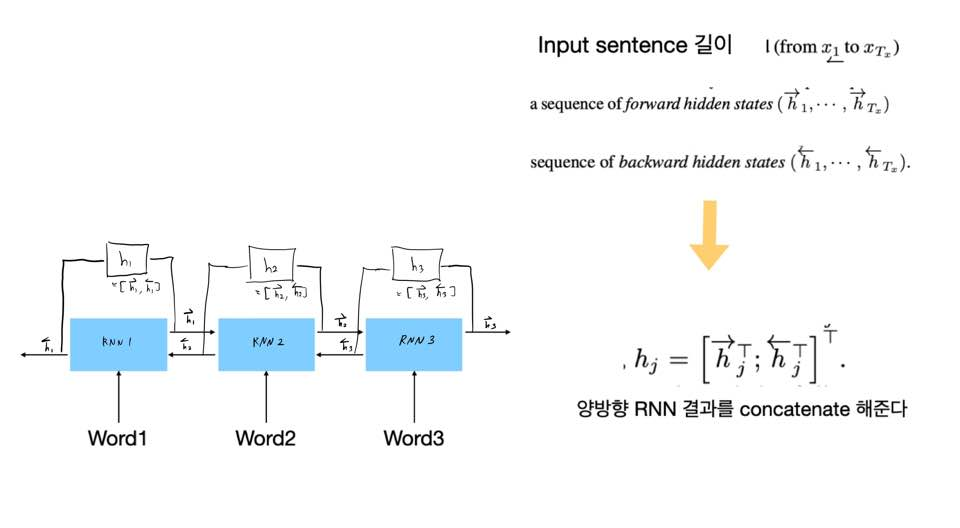

In [17]:
Image('5.jpeg',width=1000)

그 뒤에, 위 방법으로 만들어진 h1, h2, ... 를 아래와 같이 하나의 행렬로 만든다. 

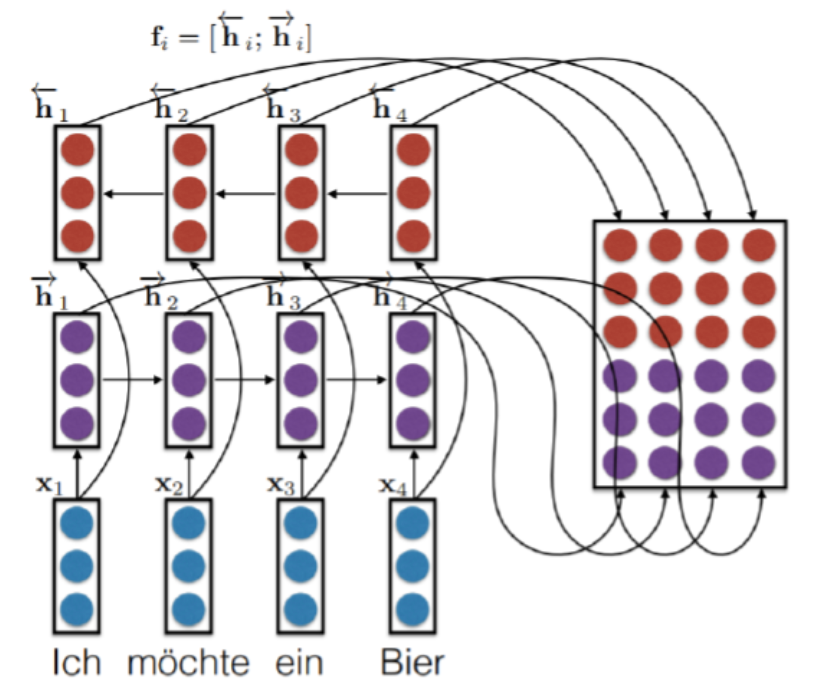

In [13]:
Image('15.png',width=400)

## 3.2 Decoder

위 인코더에서 계산한 $h_j$는 아래에서 $a_t,(1...T)$로 표현되었다. 이것은 논문에서 annotation이라고 표현된다. 이것들은 아래 그림과 같이 '+' 연산 안에서 (2)와 같이 조작된 뒤, Decoder에서의  hidden states인 $s_{t-1},s_t$를 계산하는 데 사용된다. 즉, seq2seq 같이 Decoder 내의 이전 timestep에서의 hidden states의 영향을 받으면서, **동시에** 어텐션의 영향도 받는다.


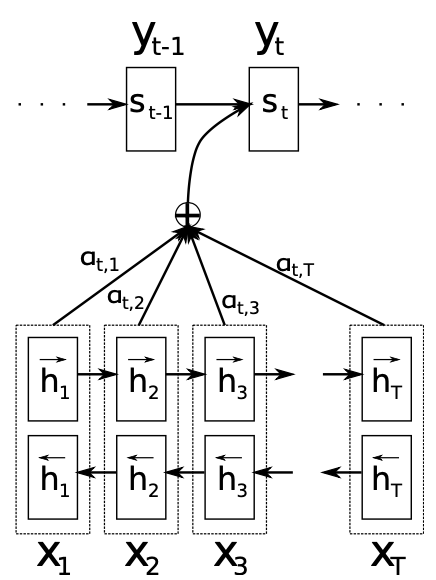

In [22]:
Image('6.png',width=300)

이것은 논문에서 아래 같이 표현된다:  
  
$$ s_i = f(s_{i-1}, y_{i-1}, c_i)$$
- $c_i$: context vector (인코더 내의 annotation (h)와, 디코더 내의 hidden states를 이용하여 구한다.  **이것이 Attention Layer에서 계산되어 나온 최종 산물이다. 이것을 어떻게 구하는지에 대해 주목해보자!**
 > $c_i = \sum_{j=1}^{Tx} \alpha_{ij}h_j$  
   - $\alpha_{ij} = \frac{exp(e_{ij})}{\sum_{k=1}^{Tx} exp(e_{ik})}$  
    - $e_{ij} = a(s_{i-1},h_j)$ `where e(energy)는 score라고 간주된다.`  
      - $a(s_{i-1},h_j)$ = $v_a^{\rm T} tanh(W_a s_{i-1}+U_ah_j)$  
        - 위 식은 [1]의 저자 방식으로 계산된 것이다. 이 방식이 아닌 다른 방식으로 계산하는 방법도 널리 사용된다. [4] 를 참고해보라.
      - $s_{i-1}$는 디코더 내의 i-1 th 위치에서의 hidden states이다.  
      - $h_j$는 인코더 내의 j th 위치에서의 annotation이다.  
      - 이 $e_{ij}$는 j 번째 위치 주변의 inputs과 i 번째 위치의 output이 **얼마나 잘 매치하는가(얼마나 관련이 있는가)**에 대한 점수를 나타낸다.  
  
- $y_{i-1}$: 디코더의 i 번째 위치에서의 target word  
- $s_{i-1}$: 디코더의 (i-1) 번째 위치의 hidden state

### 3.2.1 정리

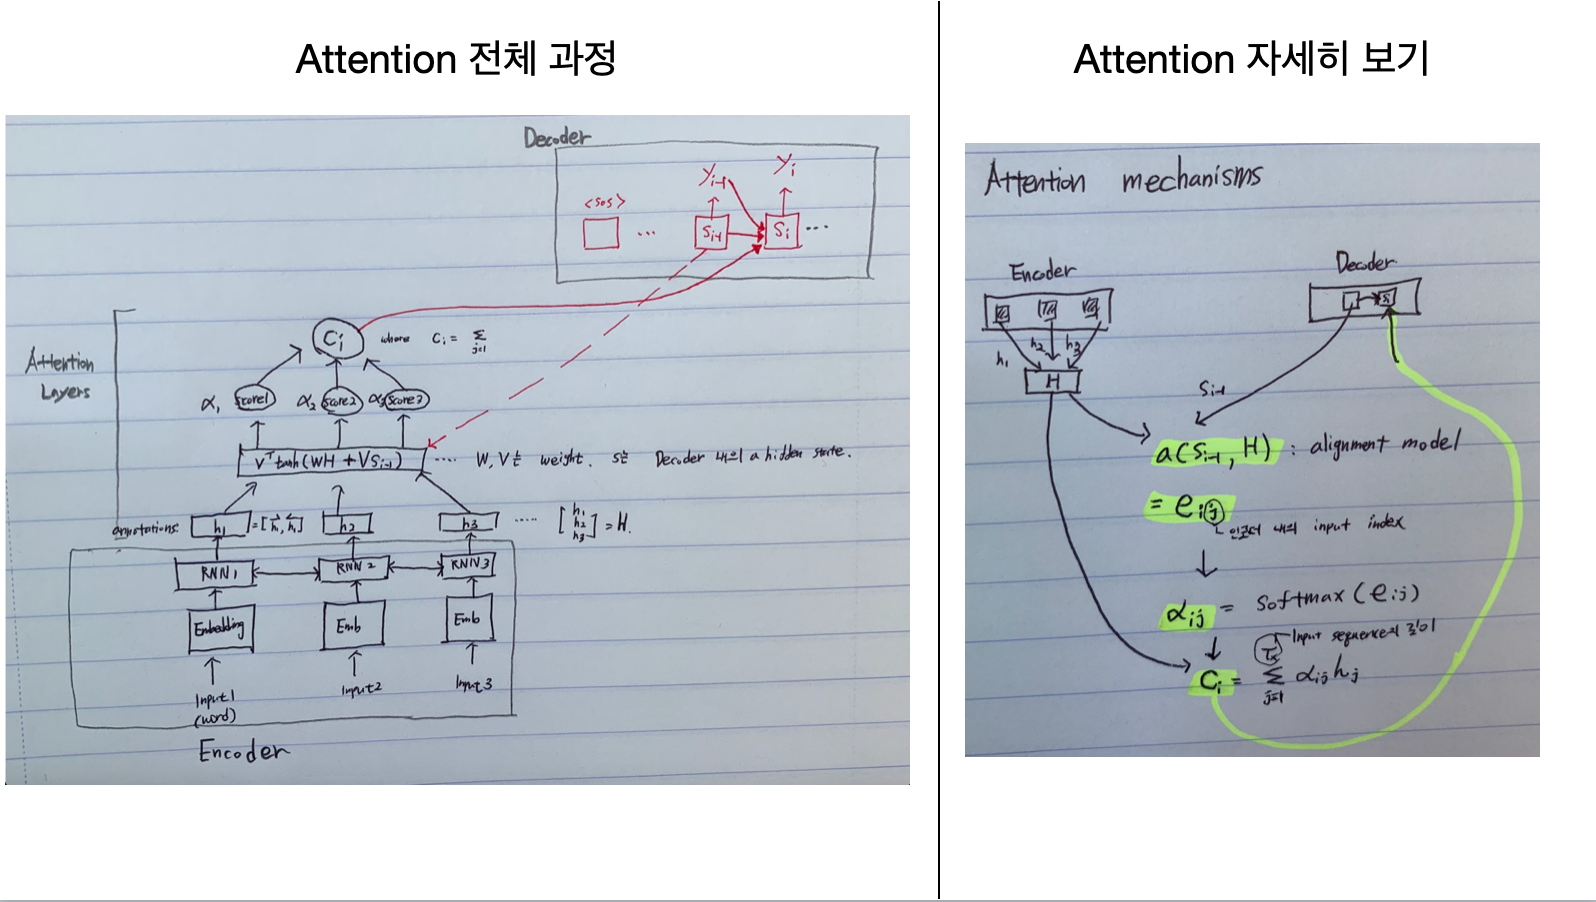

In [15]:
Image('18.png')

## 3.3 Mechanism

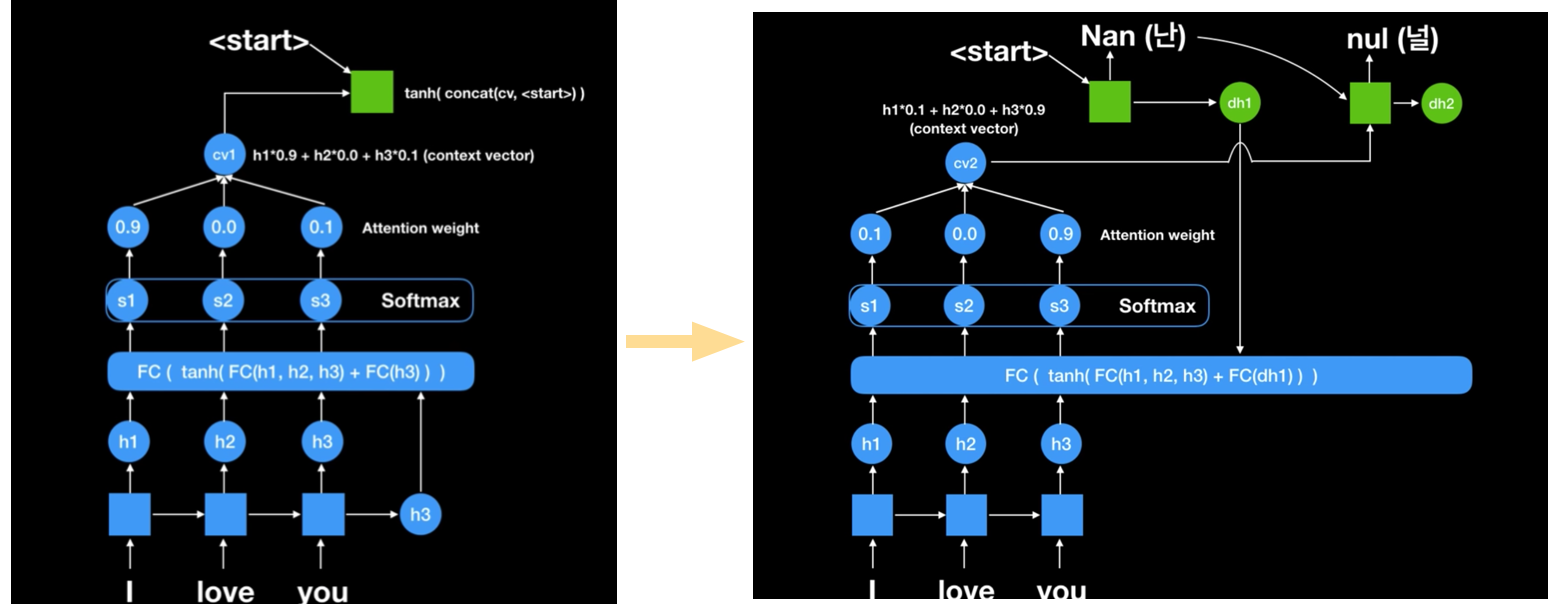

In [11]:
Image('13.png')

# References  
[1] Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio. "Neural machine translation by jointly learning to align and translate." arXiv preprint arXiv:1409.0473 (2014).  
[2] https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/ (handout 4)  
[3] https://blog.floydhub.com/attention-mechanism/ 어텐션 개념과 코드를 모두 공부하기에 매우 친절한 블로그  

[4] https://dukeyang.tistory.com/8  
[5] https://www.youtube.com/watch?v=WsQLdu2JMgI  
[6] https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/10/06/attention/